<a href="https://colab.research.google.com/github/chape8/Signal-Processing-III/blob/main/miniProyecto1_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

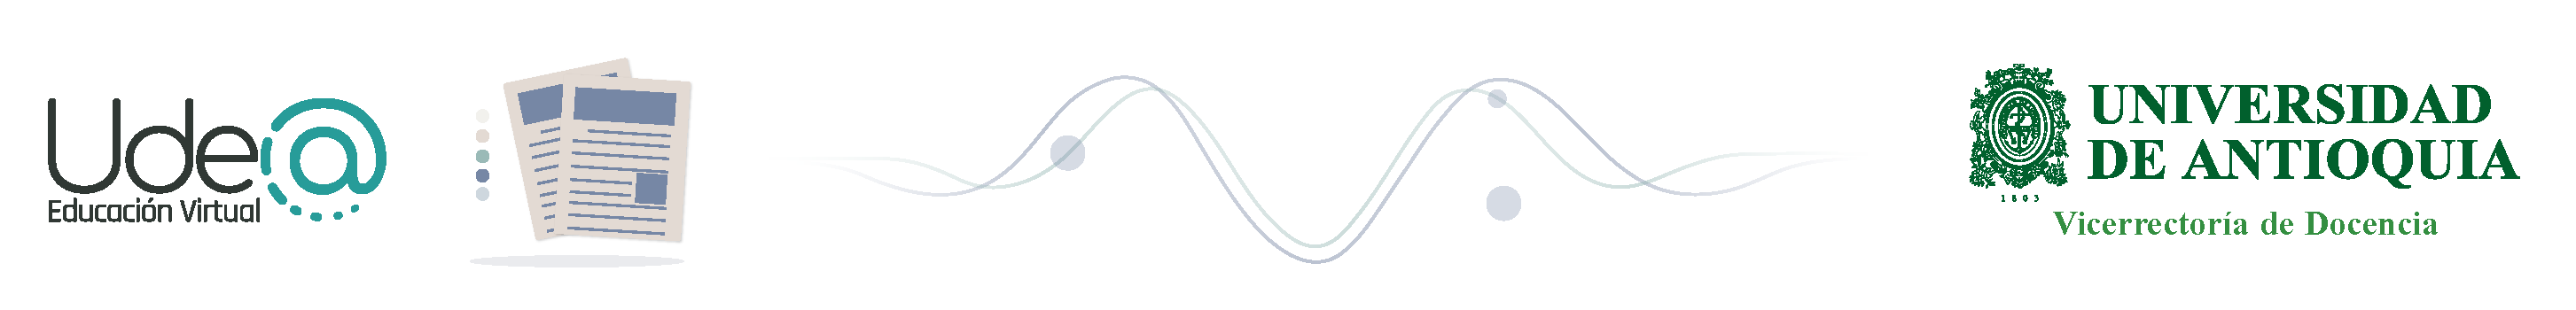

# Affective Computing Analysis

**Tratamiento de Señales III**

*Prof. Hernán Felipe García Arias*

*Facultad de Ingeniería*

*Universidad de Antioquia*

*2022-1*



>This project aims to characterize physiological patterns on multivariate signals such as EEG, ECG, EOG, and EMG to capture relevant patterns that define an emotional process.









## Cargar bases de datos de computación afectiva


La base de datos [DEAP](http://www.eecs.qmul.ac.uk/mmv/datasets/deap/index.html) es un conjunto de datos multimodal para el análisis de los estados afectivos humanos. El electroencefalograma (EEG) y las señales fisiológicas periféricas de 32 participantes se registraron mientras cada uno miraba 40 extractos de videos musicales de un minuto de duración. Los participantes calificaron cada video en términos de niveles de excitación (arousal), valencia, me gusta / no me gusta, dominio y familiaridad. Para 22 de los 32 participantes, también se grabó un video de cara frontal. Se utilizó un método novedoso para la selección de estímulos, utilizando la recuperación por etiquetas afectivas del sitio web last.fm, detección de videos destacados y una herramienta de evaluación en línea.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

#ruta = '/content/drive/MyDrive/Colab_Notebooks/Miniproyecto1/'
ruta = '/content/drive/MyDrive/Señales3/ArchivosMiniProy1/'
fileName = 'affetiveDB_1.mat'
db = sio.loadmat(ruta+fileName)


In [5]:
X = db['data']
X.shape

(40, 40, 6528)

### Dataset description

La base de datos se le removieron los 3 segundos iniciales de acondicionamiento. El arreglo X contiene todas las respuestas emocionales de las señales biológicas, para 40 videos diferentes. El arreglo se organiza de la forma

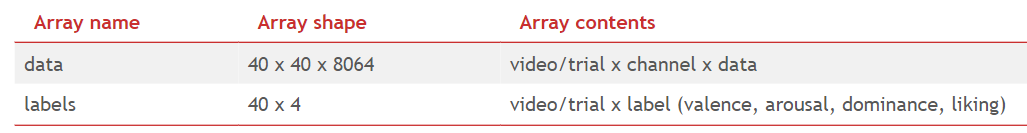

La siguiente tabla muestra el diseño de canales y el preprocesamiento realizado:

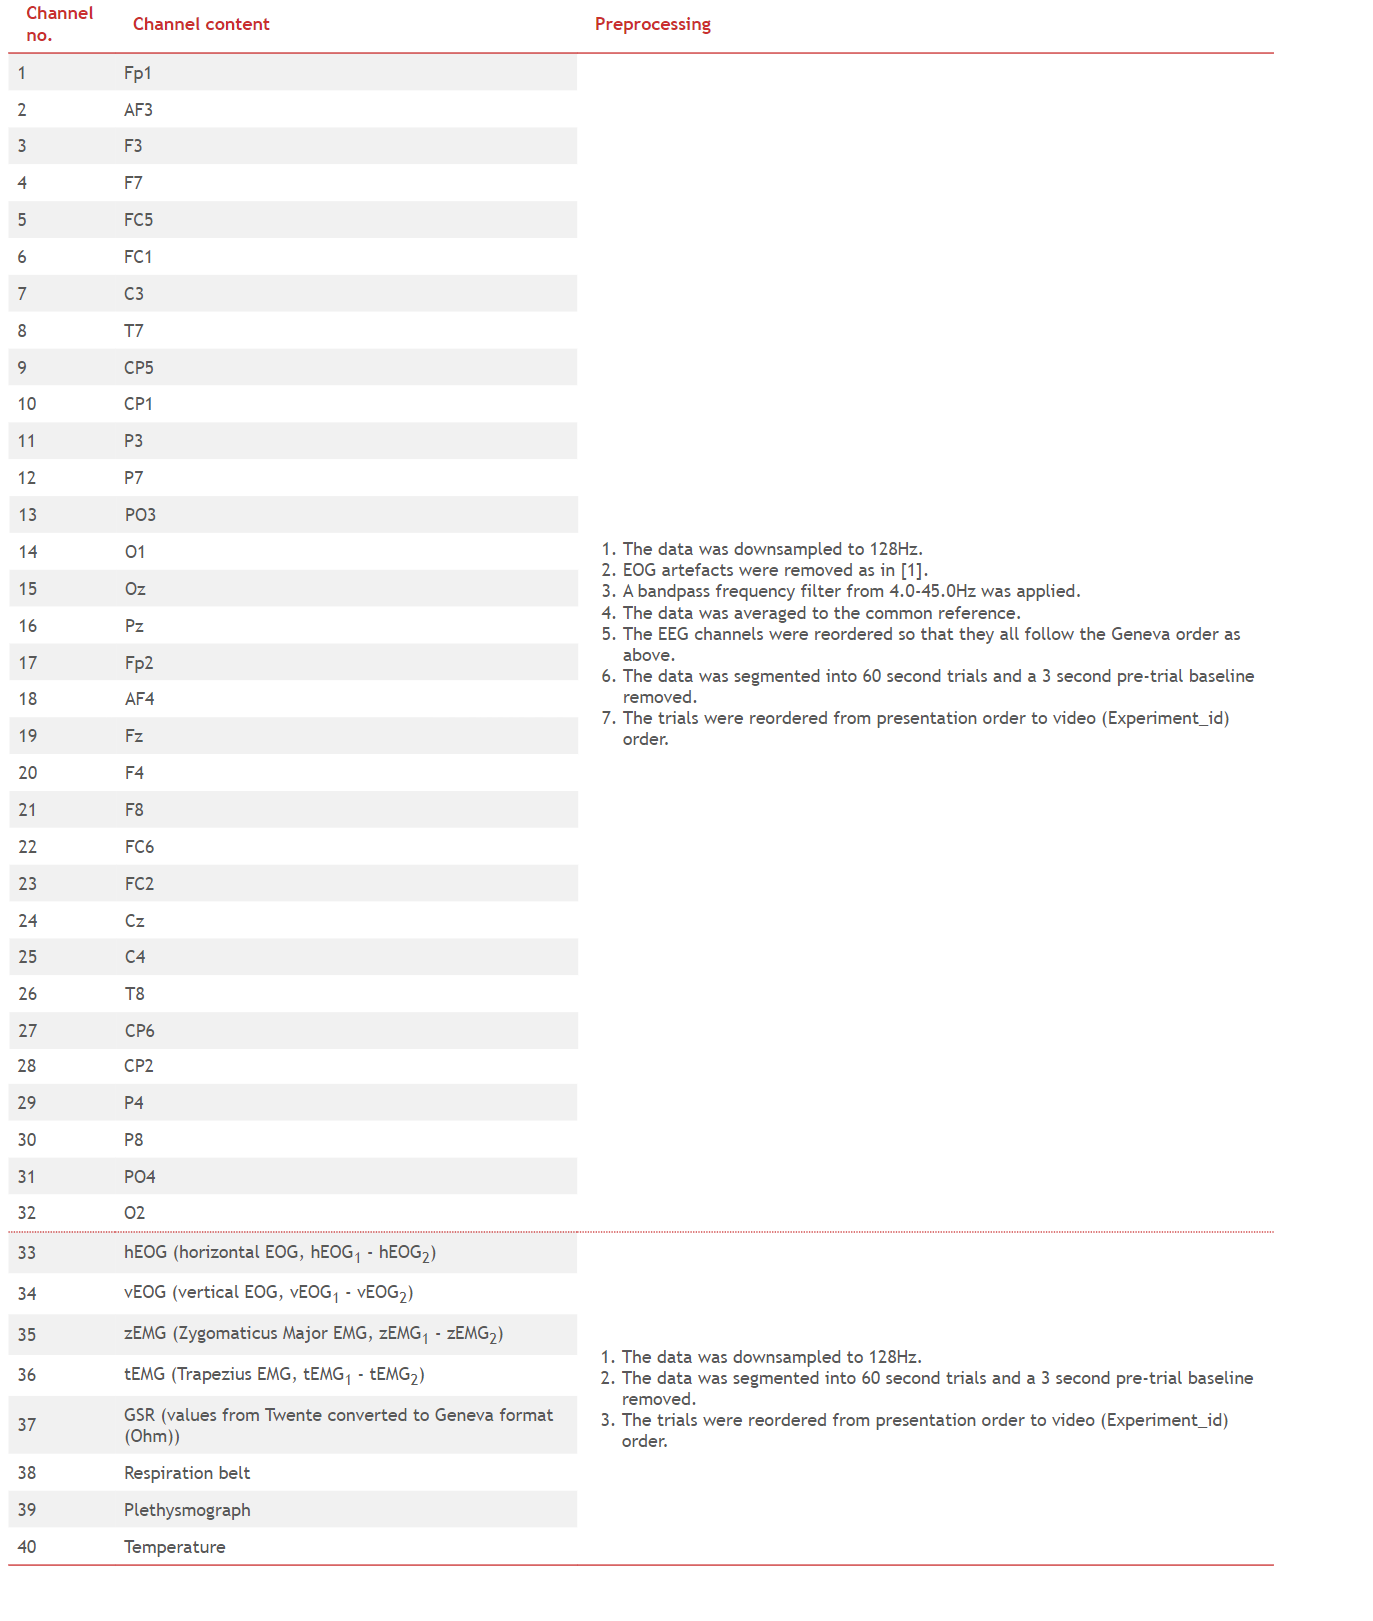

## Siglas señales fisiológicas

EEG: señales electroencefalográficas 
Generalmente son 32 canales 

EOG: electrooculograma (2 señales) movimientos verticales y horizontales

EMG: electromiogramas (2 señales) para los movimientos de los músculos (en la base de datos se capturó la señal del rostro).

Respiration belt:  banda que mide la frecuencia respiratoria

Temperatura: Mide la temperatura de la piel

Plethimograph:  Un pletismógrafo es un instrumento para medir cambios de volumen dentro de un órgano o de todo el cuerpo (generalmente como resultado de fluctuaciones en la cantidad de sangre o aire que contiene). Nos sirve como medida de el rítmo cardiaco (HR)

## Gráfica de una señal emocional

Por ejemplo si queremos obtener la señal de **respiration belt (respiración)** de la base de datos para el video número 15 (i.e., por elegir alguno), debe acceder a los datos mediante:

In [49]:
from scipy.signal import butter, lfilter, freqz, sosfilt
from scipy import signal
from scipy.fft import fft
import scipy.signal
from scipy.signal import find_peaks
import pandas as pd
import seaborn as sns

# Filtros

In [18]:


def butter_bandpass(lowcut, highcut, fs, order):
    #nyq = 0.5 * fs
    #low = lowcut / nyq
    #high = highcut / nyq
    sos_fil = butter(order, [lowcut, highcut], btype='band',output='sos',fs=128,analog=False)
    return sos_fil

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos,data)
    return y

def butter_lowpass(cut, fs, order):
    #nyq = 0.5 * fs
    #low = lowcut / nyq
    #high = highcut / nyq
    sos_fil = butter(order, cut, btype='low',output='sos',fs=128,analog=False)
    return sos_fil

def butter_lowpass_filter(data, cut, fs, order):
    sos = butter_lowpass(cut, fs, order=order)
    w, h = signal.sosfreqz(sos)
    '''plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.axvline(cut, color='green') # cutoff frequency
    plt.show()'''
    y = sosfilt(sos,data)
    return y

In [10]:
def getFeatures(trial, X):
  caracteristicas = []
  caracteristicas_GSR = GSR(trial, X) 
  caracteristicas = caracteristicas + caracteristicas_GSR
  caracteristicas_BVP = BVP(trial, X)
  caracteristicas = caracteristicas + caracteristicas_BVP
  caracteristicas_RP = RP(trial, X)
  caracteristicas = caracteristicas + caracteristicas_RP
  caracteristicas_ST = ST(trial, X)
  caracteristicas = caracteristicas + caracteristicas_ST
  caracteristicas_EOG = EOG(trial, X)
  caracteristicas = caracteristicas + caracteristicas_EOG
  caracteristicas_EEG = EEG(trial, X)
  caracteristicas = caracteristicas + caracteristicas_EEG
  return caracteristicas

# GSR

- Average Skin Resistance
- Average Rising Time
- 10 Spectral power in the [0-2.4]Hz bands

In [11]:
def GSR(trial, X):
  channel = 37
  skin_resistance = X[trial-1,channel-1,:]
  caracteristicas = []
  #Calculating average skin resistance

  average_skin_resistance = round(np.average(skin_resistance),4)
  #print("ASR: "+str(average_skin_resistance))
  caracteristicas.append(average_skin_resistance)

  #Calculating average rising time

  contador = 0
  time = []
  for i in range(0,len(skin_resistance)-1):
      if skin_resistance[i+1] >= skin_resistance[i]:
          contador += 1
      else:
          if contador > 32:
            time.append(contador/128)
          contador=0
  if contador > 32: #This 'if' is useful when the signal ends still rising 
    time.append(contador/128)

  #print("Rising times: " +str(time))
  average_rising_time = round(np.average(time),4)
  #print("ART: "+str(average_rising_time)+" secs")

  caracteristicas.append(average_rising_time)

  #Calculating 10 spectral power in the [0-2.4]Hz Bands

  # 1. Filtering the signal in the band requeried

  filtered_skin_resistance = butter_lowpass_filter(skin_resistance, cut=2.4, fs=128, order=8)

  ts = len(filtered_skin_resistance)/128.
  time = np.linspace(0,ts,len(filtered_skin_resistance))

  # 2. Calculating FFT
 
  yf = fft(filtered_skin_resistance)

  yf_aux = 2.0/len(filtered_skin_resistance) * np.abs(yf[1:len(filtered_skin_resistance)//2])


  potencias = []
  aux = yf_aux
  #print(aux)
  for i in range(0,10):
    potencias.append(np.max(aux))
    caracteristicas.append(np.max(aux))
    result = np.where(aux == np.max(aux))
    aux=np.delete(aux,result[0][0])
  #print("10 spectral powers: "+str(potencias))

  return caracteristicas

## Blood Volume Preasure

-Average and standard deviation of HR.

-Spectral power in the bands ([0.1-0.2]Hz, [0.2-0.3]Hz, [0.3-0.4]Hz)

In [12]:
def BVP(trial, X):
  caracteristicas=[]
  channel = 39 # canal de la señal fisiológica
  
  BloodVol = X[trial,channel-1,:]
  #print(BloodVol.shape)
  mean = np.nanmean(BloodVol)
  caracteristicas.append(mean)
  std = np.nanstd(BloodVol)
  caracteristicas.append(std)

  fs=128.0
  #lowcut = 0.2
  #highcut = 0.3

  lowcut = [0.1,0.2,0.3]
  highcut = [0.2,0.3,0.4]
  for lowcut, highcut in zip(lowcut, highcut):
    
    respiration = X[trial,channel-1,:]
    ts = len(respiration)/128.
    time = np.linspace(0,ts,len(respiration))

    y = butter_bandpass_filter(respiration, lowcut, highcut, fs, order=8)

    f, Pxx_den = signal.welch(y, 128., nperseg=1024)
    #plt.semilogy(f, Pxx_den)

    maximo=max(Pxx_den)
    #print(maximo)

    if lowcut==0.1:
      caracteristicas.append(maximo)      #No se como agregar la tupla con el valor maximo de la DEP y la frecuencia a la que está,sale errores
    elif lowcut==0.2:
      caracteristicas.append(maximo)
    elif lowcut==0.3:
      caracteristicas.append(maximo)
    
  return caracteristicas

#Respiration Pattern



In [13]:
def RP(trial, X):
  caracteristicas=[]
  channel = 38 

  respiration = X[trial,channel-1,:]
  respiration = butter_bandpass_filter(respiration, 0.05, 1.5, 128., order=8)
  mean = np.nanmean(respiration)

  des=np.nanstd(respiration)
  peaks2, _ = find_peaks(respiration, prominence=des)
  #print(len(peaks2))

  Num_resp=len(peaks2)
  Num_resp=(Num_resp*60)//51  #Esta regla de 3 sugeridad por el profesor puesto que la señal es de 51 segundo y breathing_rate se mide por minuto


  diff_x1 = np.diff(peaks2)
  time_peak=(sum(diff_x1)/len(diff_x1))/128.


  #plt.plot(peaks2,respiration[peaks2], "xr")
  caracteristicas.append(mean)
  caracteristicas.append(Num_resp)
  caracteristicas.append(time_peak)

  return caracteristicas

# Skin temperature

- Average Skin Temperature
- Average of its derivative
- Spectral power in the bands ([0-0.1]Hz, [0.1-0.2]Hz)

In [14]:
def ST(trial, X):
  caracteristicas=[]
  channel = 40
  trial = 18
  skin_temperature = X[trial-1,channel-1,:]

  ts = len(skin_temperature)/128.
  time = np.linspace(0,ts,len(skin_temperature))

  #Calculating average skin temperature

  average_skin_temperature = np.average(skin_temperature)
  caracteristicas.append(average_skin_temperature)
  #print("AST: "+str(average_skin_temperature))

  #Calculating average of its derivative

  derivative_skin_temperature = np.gradient(skin_temperature)/np.gradient(time)
  average_derivative_ST = np.average(derivative_skin_temperature)
  caracteristicas.append(average_derivative_ST)

  #print("ADST: "+str(average_derivative_ST))


  #Calculating spectral power in the bands ([0-0.1]Hz,[0-0.2]Hz)

  # Band [0-0.1]

  filtered_skin_temperature = butter_lowpass_filter(data = skin_temperature, cut = 0.1, fs = 128 , order = 8)


  # 2. Calculating FFT

  yf = fft(filtered_skin_temperature)

  yf_aux = 2.0/len(filtered_skin_temperature) * np.abs(yf[1:len(filtered_skin_temperature)//2])

  fs = 128 # fs
  f, Pxx_ST = signal.welch(filtered_skin_temperature, fs, nperseg=64)

  maximo1 = max(Pxx_ST)
  caracteristicas.append(maximo1)
  # Band [0.1-0.2]

  filtered_skin_temperature = butter_bandpass_filter(data = skin_temperature, lowcut = 0.1, highcut = 0.2, fs = 128 , order = 8)

  # 2. Calculating FFT
  
  yf = fft(filtered_skin_temperature)

  yf_aux = 2.0/len(filtered_skin_temperature) * np.abs(yf[1:len(filtered_skin_temperature)//2])
 
  fs = 128 # fs
  f, Pxx_ST = signal.welch(filtered_skin_temperature, fs, nperseg=64)

  maximo2 = max(Pxx_ST)
  caracteristicas.append(maximo2)

  return caracteristicas

#EMG and EOG
-Eye blinking rate, mean and variance of the signal

In [15]:
def EOG(trial, X):
  caracteristicas=[]
  channel = 33 # canal de la señal fisiológica
 
  eye = X[trial,channel-1,:]
  '''#Se realiza un filtrado similar al punto anterior pues la señal aparecia muy ruidosa y se obtienen mejores resultados
  Los valores de las frecuencias de corte fueron dejadas de manera experimental y funcionaron'''
  eye = butter_bandpass_filter(eye, 0.05, 1.5, 128., order=8)
  des = np.nanstd(eye)
  picos, _ = find_peaks(eye, prominence=des)
  Num_resp=len(picos)
  Num_resp=(Num_resp*60)//51  #Esta regla de 3 sugeridad por el profesor puesto que la señal es de 51 segundo y breathing_rate se mide por minuto
  

  mean=np.nanmean(eye)
  var=np.nanvar(eye)

  caracteristicas.append(Num_resp)
  caracteristicas.append(mean)
  caracteristicas.append(var)

  return caracteristicas

# EEG
- theta (4 to 7Hz); alpha (8 to 12Hz); beta (13 to 30Hz) spectral power for each pair of electrodes 

In [22]:
def EEG(trial, X):
  channel_pairs = [[1,17],[4,21],[3,20],[7,25],[11,29],[14,32],[2,18],[5,22],[6,23],[8,26],[9,27],[10,28],[12,30],[13,31]]
  #[Fp1,Fp2],[F7,F8],[F3,F4],[C3,C4],[P3,P4],[O1,O2],[AF3,AF4],[FC5,FC6],[FC1,FC2],[T7,T8],[CP5,CP6],[CP1,CP2],[P7,P8],[PO3,PO4]

  caracteristicas = []
  bands = [[4,7],[8,12],[13,30]]
  #[theta, alpha, beta]
  
  fs = 128 # fs
  for j in range(0,len(bands)):

    for i in range(0,len(channel_pairs)):
      left_channel = X[trial-1,channel_pairs[i][0]-1,:]
      right_channel = X[trial-1,channel_pairs[i][1]-1,:]
      electrode_pair = left_channel - right_channel
      electrode_pair = butter_bandpass_filter(electrode_pair, bands[j][0], bands[j][1], 128., order=8)
      f, Pxx_electrode_pair = signal.welch(electrode_pair, fs, nperseg=64)
      potAbso = np.sum(Pxx_electrode_pair)
      caracteristicas.append(potAbso)

    channel = [15,16,19,24]
    #[Oz, Pz, Fz, Cz]

    for i in range (0, len(channel)):
      mid_channel = X[trial-1,channel[i]-1,:]
      mid_channel = butter_bandpass_filter(mid_channel, bands[j][0], bands[j][1], 128., order=8)
      f, Pxx_electrode = signal.welch(mid_channel, fs, nperseg=64)
      potAbso = np.sum(Pxx_electrode)
      caracteristicas.append(potAbso)

  return caracteristicas

In [32]:
Matriz=[]
for i in range(0,40):
  carac = getFeatures(i, X)
  Matriz.append(carac)

print(np.shape(Matriz))


(40, 81)


## Etiquetas emocionales

Cada una de las realizaciones induce una emoción en los sujetos. Por lo tanto cada realización (de las 40) tiene sus correspondientes etiquetas de la forma:

Los modelos dimensionales sugieren que la emoción se entiende mejor cuando ocurre dentro de un espacio dimensional, más comúnmente un espacio bidimensional que abarca la valencia y la excitación. La valencia emocional describe el grado en que una emoción es positiva o negativa, mientras que la excitación se refiere a su intensidad, es decir, la fuerza del estado emocional asociado.


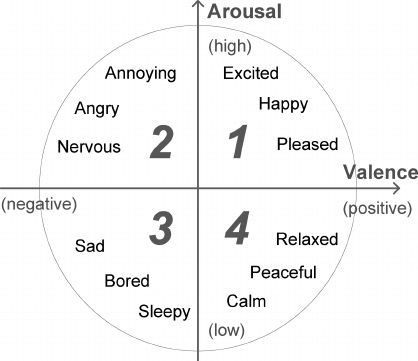

Las etiquetas están en el campo label:

labels	es una matriz de $40 \times 4$ en la cual se organiza de la forma	$video/trial \times label $ (valence, arousal, dominance, liking)

Valence	The valence rating (float between 1 and 9).
Arousal	The arousal rating (float between 1 and 9).
Dominance	The dominance rating (float between 1 and 9).
Liking	The liking rating (float between 1 and 9).


## EEG analysis

El análisis en el dominio de la frecuencia se realiza utilizando el algoritmo de Transformada Rápida de Fourier (FFT) (con una resolución de 0,125 Hz) para calcular la densidad de potencia absoluta (μV2 / Hz), la densidad de potencia relativa (%) y la frecuencia media (Hz) dentro de cada una de las subbandas. La potencia absoluta de una banda es la integral de todos los valores de potencia dentro de su rango de frecuencia. Los índices de potencia relativa (RP) para cada banda se encuentran expresando la potencia absoluta en cada banda de frecuencia como un porcentaje de la potencia absoluta (AP) sumada en las cuatro bandas de frecuencia. Para las medidas de asimetría de potencia inter-hemisférica (absoluta) para cada banda para siete sitios homólogos (AF3-AF4, F7-F8, F3-F4, FC5-FC6, T7-T8, P7-P8, O1-O2) y un conjunto adicional de diez pares de sitios de electrodos (AF3-F3, AF4-F4, F3-O1, F4-O2, FC5-P7, FC6-P8, P7-O1, P8-O2, T7-O1, T8-O2). Los índices de asimetría del hemisferio derecho (R) frente al hemisferio izquierdo (L) (R-L) se calcularon con la fórmula [(R-L) / (R + L)]. Para la simetría intra-hemisférica, las relaciones de valor anterior (A) (frontal) vs. posterior (P) (posterior) (A-P) para cada par de electrodos se derivaron con la fórmula [(A-P) / (A + P)]. Las variables de EEG de potencia absoluta y asimetría se pueden transformar logarítmicamente (log (χ)) y las variables de potencia relativa se pueden transformar mediante log [χ ÷ (1 - χ)] con el fin de normalizar la distribución de los datos [63-65].

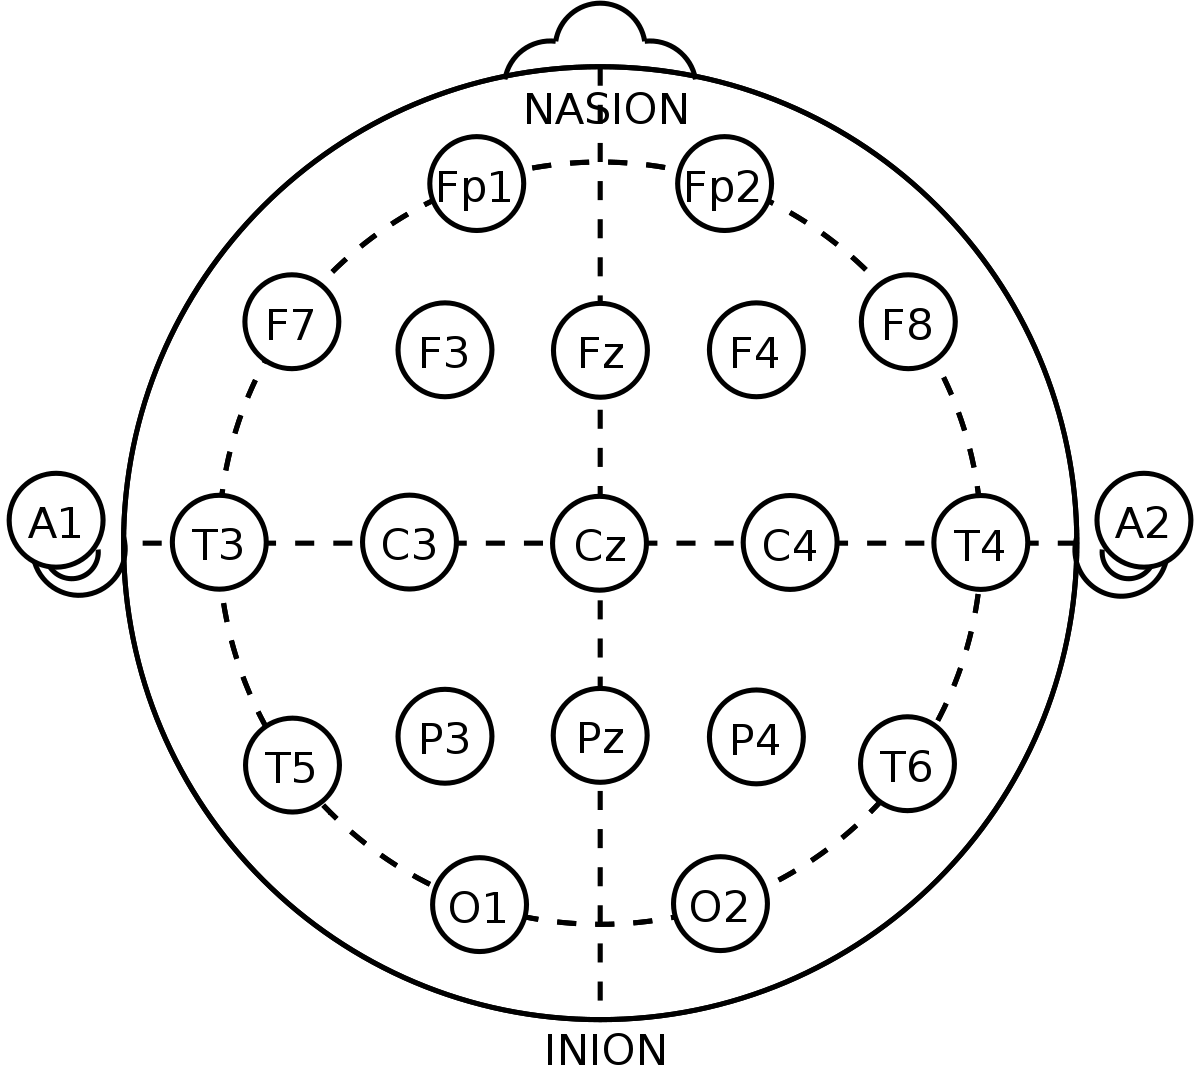

## Visualización de las etiquetas emocionales

Para esto, se realizará un agrupamiento de las etiqeutas de $arousal$, $valence$ en 3 grupos:

1. Emociones Negativas: arousal $[1-3]$ y valence $[1-3]$. 
2. Emociones Neutras: arousal $[4-6]$ y valence $[4-6]$.
3. Emociones Positivas: arousal $[7-9]$ y valence $[7-9]$. 

In [46]:
exc = 'excited'
pls = 'pleased'
ann = 'annoying'
nerv = 'nervous'
sad = 'sad'
slp = 'sleepy'
clm = 'calm'
rlx = 'relaxed'

labels = db['labels']


Valence = labels[:,0]
Arousal = labels[:,1]
emociones=[]

for i in range(0,40):
  if (Arousal[i]>=1 and Arousal[i]<=5):
    if(Valence[i]>=1 and Valence[i]<=3):
      emociones.append(sad)
    if(Valence[i]>3 and Valence[i]<=5):
      emociones.append(slp)
    if(Valence[i]>5 and Valence[i]<=7):
      emociones.append(clm)
    if(Valence[i]>7 and Valence[i]<=9):
      emociones.append(rlx)

  if (Arousal[i]>5 and Arousal[i]<=9):
    if (Valence[i]>=1 and Valence[i]<=3):
      emociones.append(nerv)
    elif (Valence[i]>3 and Valence[i]<=5):
      emociones.append(ann)
    if (Valence[i]>5 and Valence[i]<=7):
      emociones.append(exc)
    elif (Valence[i]>7 and Valence[i]<=9):
      emociones.append(pls)



40


In [51]:
dataFrame = pd.DataFrame(data = Matriz)

dataFrame['Emociones'] = emociones
SubData1=dataFrame.iloc[:,0:18]
SubData1['Emociones'] = emociones

<Figure size 432x288 with 0 Axes>

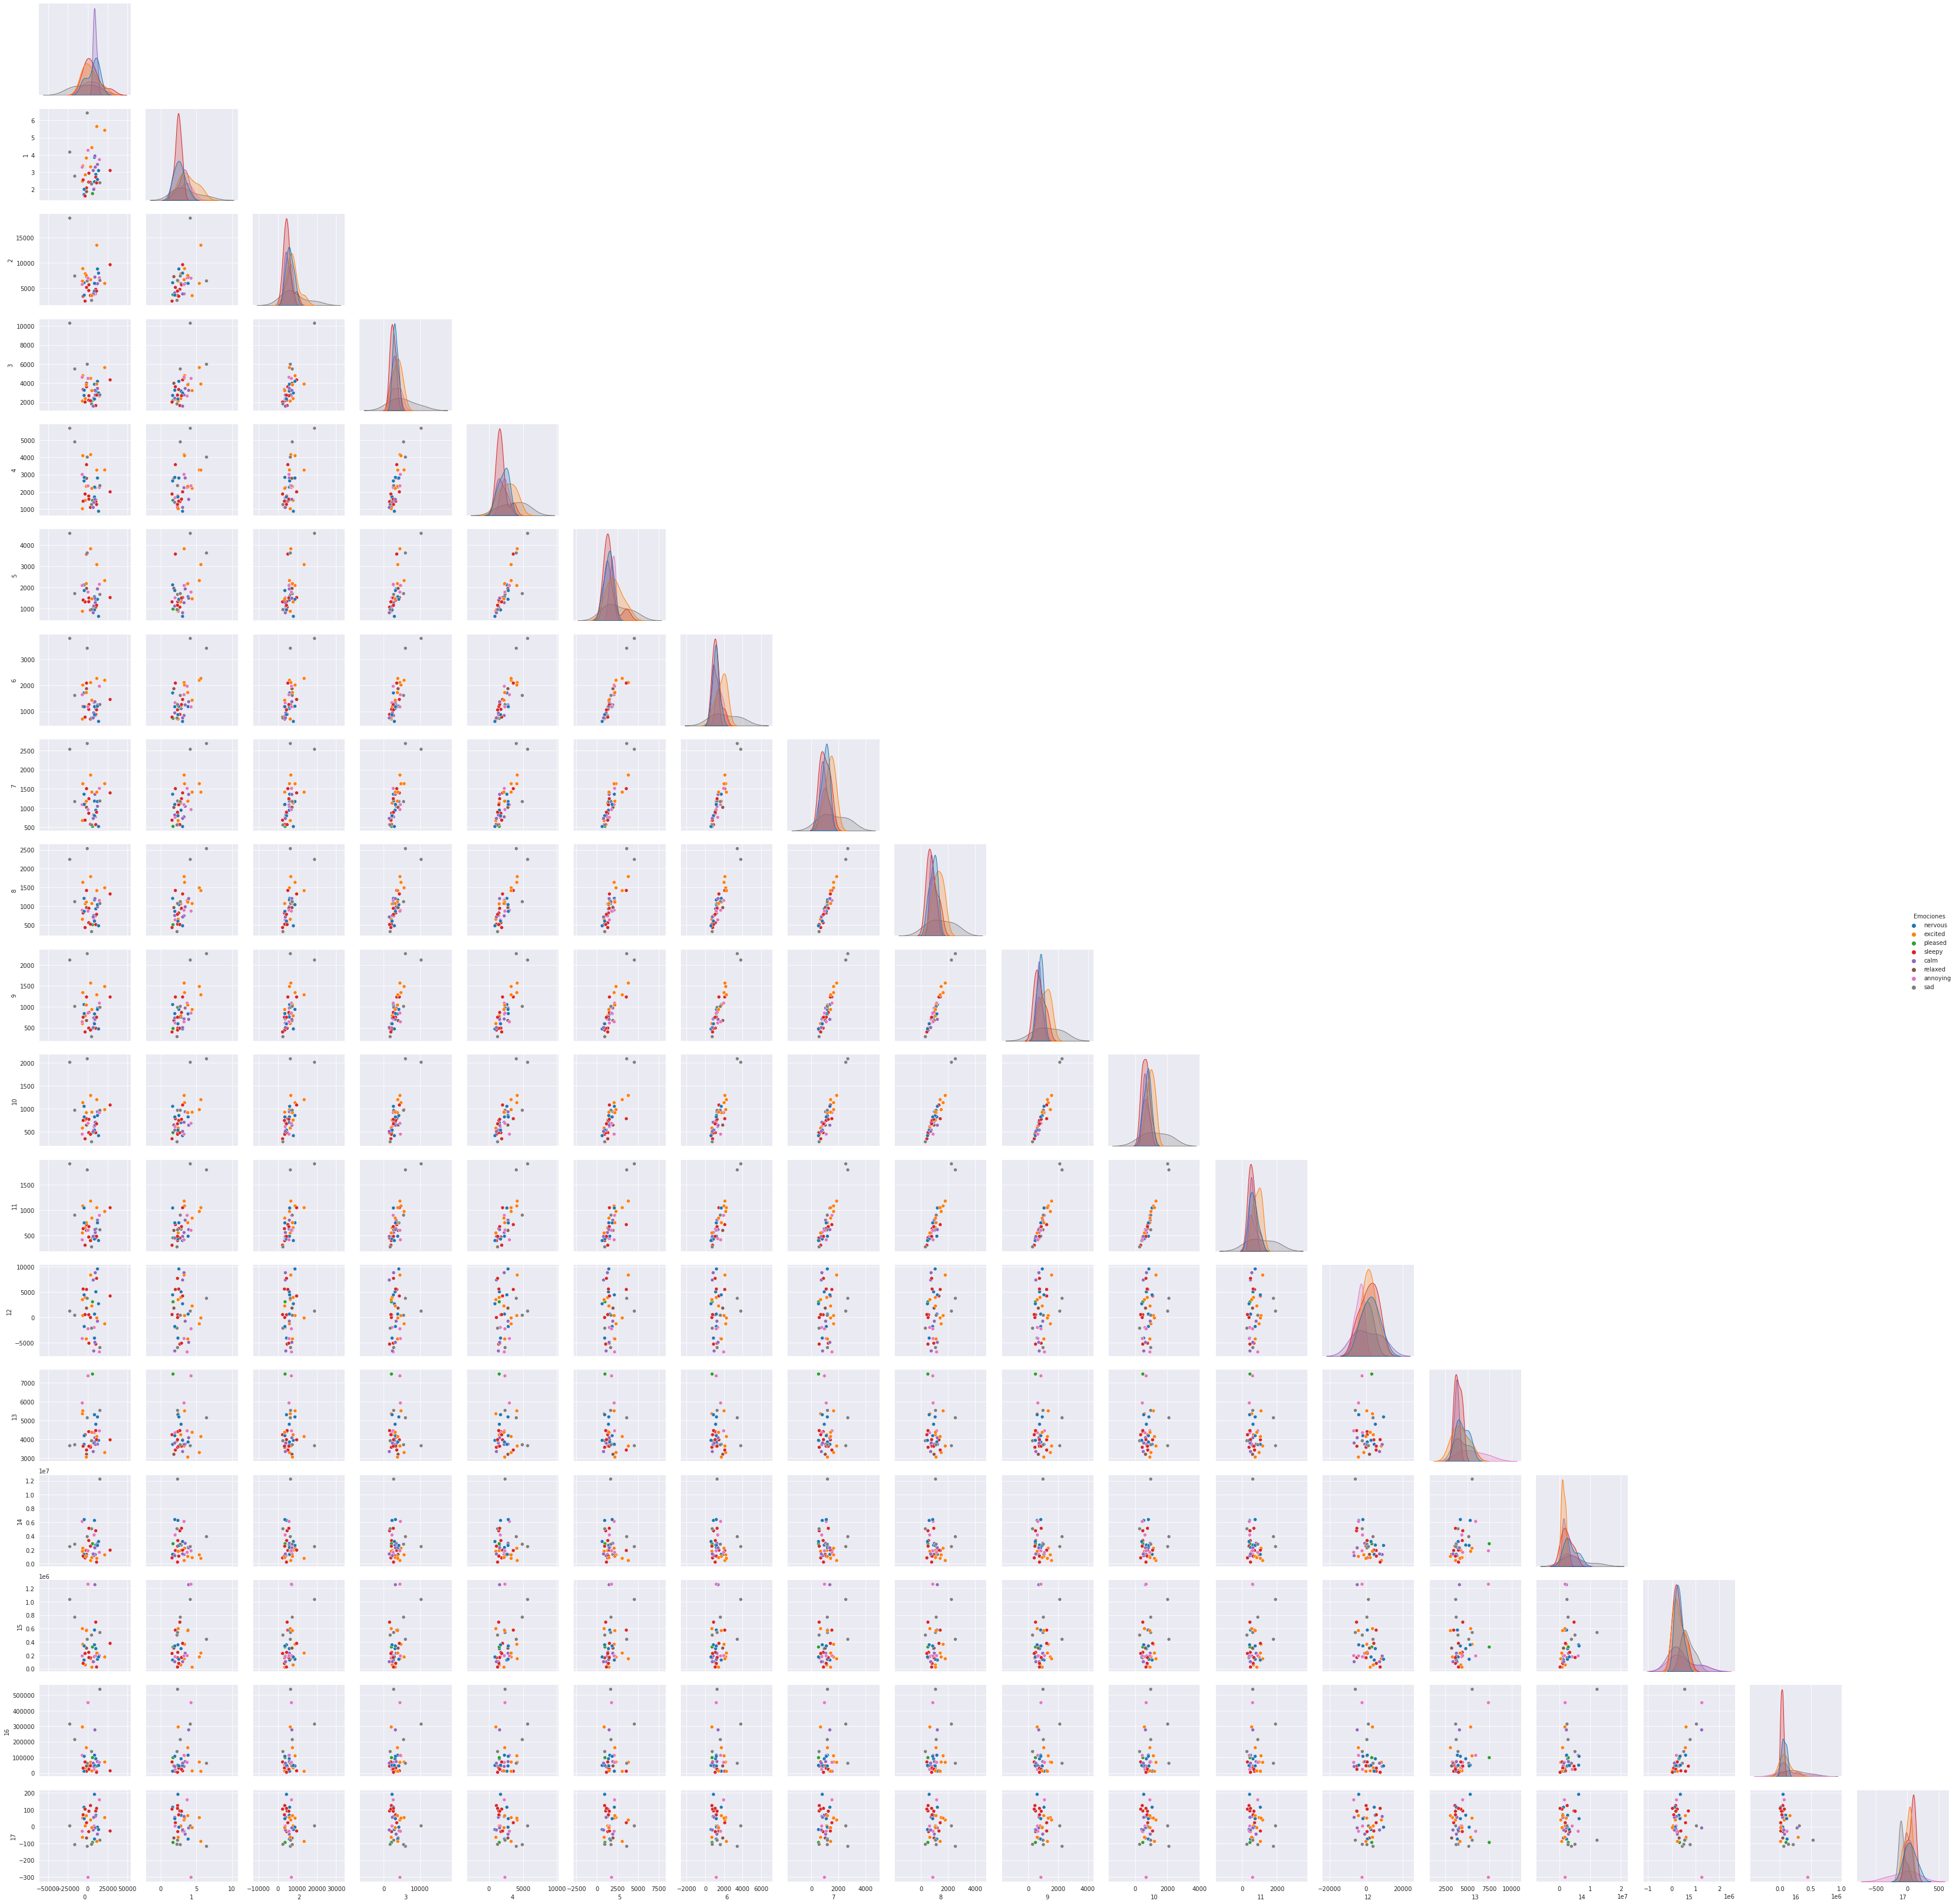

<Figure size 432x288 with 0 Axes>

In [52]:
sns.set_style('darkgrid')
#fig, ax = plt.subplots()


unique = SubData1['Emociones'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

ax = sns.pairplot(data=SubData1,  hue='Emociones', palette=palette, corner = True)

plt.tight_layout()
plt.figure()